# Modèle 2 - Concaténation par heure

Suite à l'echec du modèle 1 à cause du bruit, ce nouveau modèle a été généré avec concatenation de features. Le dataset étant plus light, les modèles vont être entrainés sur ce notebook, optimisé, evalués et explorés ici

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error#, mean_squared_log_error

%matplotlib inline

## Preprocessing

In [6]:
df = pd.read_csv("dataset/merged/model2_dataset.csv")
df.dropna(axis=1, how="all", inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278083 entries, 0 to 278082
Data columns (total 7 columns):
WEEK                   278083 non-null int64
DAY_OF_WEEK            278083 non-null int64
FL_HOUR                278083 non-null int64
UNIQUE_CARRIER         278083 non-null object
ORIGIN_AIRPORT_RANK    278083 non-null float64
DEP_DELAY              277654 non-null float64
NUM_FLIGHT             278083 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 14.9+ MB


OHE des features catégoriques / non linéaires

In [8]:
df = pd.concat([df, pd.get_dummies(df["UNIQUE_CARRIER"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["DAY_OF_WEEK"], prefix="DAY_")], axis=1)
df = pd.concat([df, pd.get_dummies(df["WEEK"], prefix="WEEK_")], axis=1)

df.drop("UNIQUE_CARRIER", axis=1, inplace = True)
df.drop("DAY_OF_WEEK", axis=1, inplace = True)
df.drop("WEEK", axis=1, inplace = True)

In [9]:
df_OHE = df.copy()
df_OHE = pd.concat([df_OHE, pd.get_dummies(df["ORIGIN_AIRPORT_RANK"], prefix="RANK_")], axis=1)
df_OHE.drop("ORIGIN_AIRPORT_RANK", axis=1, inplace = True)

Les heures sans vol ont une moyenne nulle, du coup je supprime ces enregristrements

In [10]:
df["DEP_DELAY"].isnull().sum()

429

In [11]:
df = df[df["DEP_DELAY"].notnull()]
df_OHE = df_OHE[df_OHE["DEP_DELAY"].notnull()]

## Préparation des modèles

In [12]:
X = df.drop("DEP_DELAY", axis=1)
y = df["DEP_DELAY"]

X_OHE = df_OHE.drop("DEP_DELAY", axis=1)
y_OHE = df_OHE["DEP_DELAY"]

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_scale_OHE = scaler.fit_transform(X_OHE)

on fixe random state par la suite pour splitter les 2 datasets de la même façon pour comparer les outputs

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE = train_test_split(X_scale_OHE, y_OHE, test_size=0.2, random_state=42)

## Mise en place des modèles

In [15]:
from sklearn.linear_model import SGDRegressor

### SGDR sans OHE sur les rang des aéroports

In [16]:
from sklearn.model_selection import ParameterGrid

params = [
    {
    "loss" : ["huber"],
    "penalty" : [None, 'l2', 'l1'],
    "max_iter": [3, 5, 10]
    },
    {
    "loss" : ["huber"],
    "penalty" : ['elasticnet'],
    "l1_ratio" : [0.15, 0.50, 0.85],
    "max_iter": [3, 5, 10]
    }]

for param in ParameterGrid(params):
    model = SGDRegressor(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    print("SGD_Regressor ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': None}) : MSE 658.2584, MAE 11.5786

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l2'}) : MSE 658.5302, MAE 11.5829

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l1'}) : MSE 658.6291, MAE 11.5895

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': None}) : MSE 656.1401, MAE 11.4761

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l2'}) : MSE 656.5209, MAE 11.4837

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l1'}) : MSE 656.5656, MAE 11.4919

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': None}) : MSE 652.6672, MAE 11.3115

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l2'}) : MSE 653.2621, MAE 11.3257

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l1'}) : MSE 653.4329, MAE 11.3339

SGD_Regressor ({'l1_ratio': 0.15, 'loss': 'huber', 'max_iter': 3, 'penalty': 'elasticnet'}) : MSE 658.6385, MAE 11.5838

SGD_Regressor ({'l1_r

In [17]:
param = {'loss': 'huber', 'max_iter': 10, 'penalty': None}
model = SGDRegressor(**param)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print(MSE, MAE)

652.719631821 11.3115215234


### SGDR avec OHE sur les rang des aéroports

In [14]:
from sklearn.model_selection import ParameterGrid

params = [
    {
    "loss" : ["huber"],
    "penalty" : [None, 'l2', 'l1'],
    "max_iter": [3, 5, 10]
    },
    {
    "loss" : ["huber"],
    "penalty" : ['elasticnet'],
    "l1_ratio" : [0.15, 0.50, 0.85],
    "max_iter": [3, 5, 10]
    }]

for param in ParameterGrid(params):
    model = SGDRegressor(**param)
    model.fit(X_train_OHE, y_train_OHE)

    y_pred_OHE = model.predict(X_test_OHE)

    MSE = mean_squared_error(y_test_OHE, y_pred_OHE)
    MAE = mean_absolute_error(y_test_OHE, y_pred_OHE)
    print("SGD_Regressor ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': None}) : MSE 659.1134, MAE 11.4888

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l2'}) : MSE 659.2655, MAE 11.4936

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l1'}) : MSE 659.6626, MAE 11.5010

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': None}) : MSE 656.2138, MAE 11.3778

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l2'}) : MSE 656.6678, MAE 11.3858

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l1'}) : MSE 656.8696, MAE 11.3938

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': None}) : MSE 652.2052, MAE 11.2355

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l2'}) : MSE 652.6749, MAE 11.2482

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l1'}) : MSE 652.8597, MAE 11.2558

SGD_Regressor ({'l1_ratio': 0.15, 'loss': 'huber', 'max_iter': 3, 'penalty': 'elasticnet'}) : MSE 659.3410, MAE 11.4949

SGD_Regressor ({'l1_r

In [18]:
param_OHE = {'loss': 'huber', 'max_iter': 10, 'penalty': None}
model_OHE = SGDRegressor(**param_OHE)
model_OHE.fit(X_train_OHE, y_train_OHE)

y_pred_OHE = model_OHE.predict(X_test_OHE)

MSE = mean_squared_error(y_test_OHE, y_pred_OHE)
MAE = mean_absolute_error(y_test_OHE, y_pred_OHE)
print(MSE, MAE)

652.264193594 11.2355162522


La version OHE est plus accurate, on la garde pour entrainer le boosting

### Boosting sur version OHE

In [19]:
from sklearn.ensemble import AdaBoostRegressor

In [27]:
best_params_single_SGDR = {'loss': 'huber', 'max_iter': 10, 'penalty': None}

params = [
{
    "base_estimator" : [SGDRegressor(**best_params_single_SGDR)],
    "n_estimators" : [2, 5, 10, 20],
    "loss" : ['linear', 'square', 'exponential']
}]

for param in ParameterGrid(params):
    booster = AdaBoostRegressor(**param)
    booster.fit(X_train_OHE, y_train_OHE)

    y_pred_OHE_booster = booster.predict(X_test_OHE)
    MSE = mean_squared_error(y_test_OHE, y_pred_OHE_booster)
    MAE = mean_absolute_error(y_test_OHE, y_pred_OHE_booster)

    print("Booster ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False), 'loss': 'linear', 'n_estimators': 2}) : MSE 652.3083, MAE 11.2374

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False), 'loss': 'linear', 'n_estimators': 5}) : MSE 648.7333, MAE 11.2433

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, pen

In [20]:
final_param = {'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
               fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
               loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
               random_state=None, shuffle=True, tol=None, verbose=0,
               warm_start=False), 'loss': 'exponential', 'n_estimators': 5}

booster = AdaBoostRegressor(**final_param)
booster.fit(X_train_OHE, y_train_OHE)

y_pred_OHE_booster = booster.predict(X_test_OHE)
MSE = mean_squared_error(y_test_OHE, y_pred_OHE_booster)
MAE = mean_absolute_error(y_test_OHE, y_pred_OHE_booster)

print(MSE, MAE)

647.525975782 11.237983548


On a donc le modèle fitté que l'on peut explorer

## Comparaison des predictions

In [21]:
start = 100
for x, y, z, a in zip(y_test[start:start+10], y_pred[start:start+10], y_pred_OHE[start:start+10], y_pred_OHE_booster[start:start+10]):
    print(x , "\t", y, "\t", z, "\t", a)

6.92857142857 	 3.08073220371 	 2.81503839816 	 3.23048832163
3.0 	 -0.0623232451083 	 -1.5842132886 	 -1.24019784663
1.0 	 2.2974337976 	 2.27084376283 	 2.63009784529
-5.75 	 -2.98421966672 	 -4.31915752562 	 -3.94379332501
-3.16666666667 	 -1.06596435909 	 -1.28792099435 	 -0.977124013072
0.75 	 2.37899190508 	 1.05304724378 	 1.51369719699
-4.0 	 1.77310115381 	 2.11652381214 	 2.58339319792
10.5 	 0.891037698841 	 -0.533124160999 	 -0.272631935631
-0.722222222222 	 3.99945562843 	 4.45114498808 	 4.71973487739
16.4571428571 	 2.11999668471 	 1.87759592375 	 2.07018722216


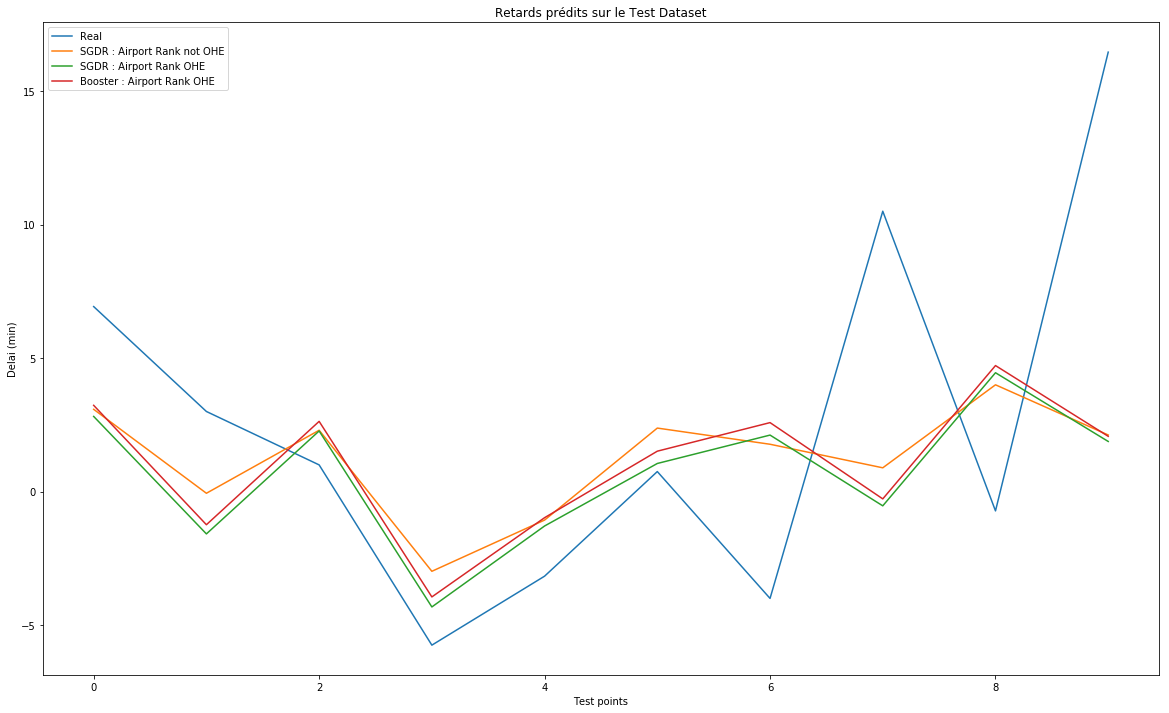

In [23]:
width = 10
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Real")
plt.plot(range(width), y_pred[start:start+width], label="SGDR : Airport Rank not OHE")
plt.plot(range(width), y_pred_OHE[start:start+width], label="SGDR : Airport Rank OHE")
plt.plot(range(width), y_pred_OHE_booster[start:start+width], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset")
plt.savefig("img/predict_zoom_in.png")
plt.show()

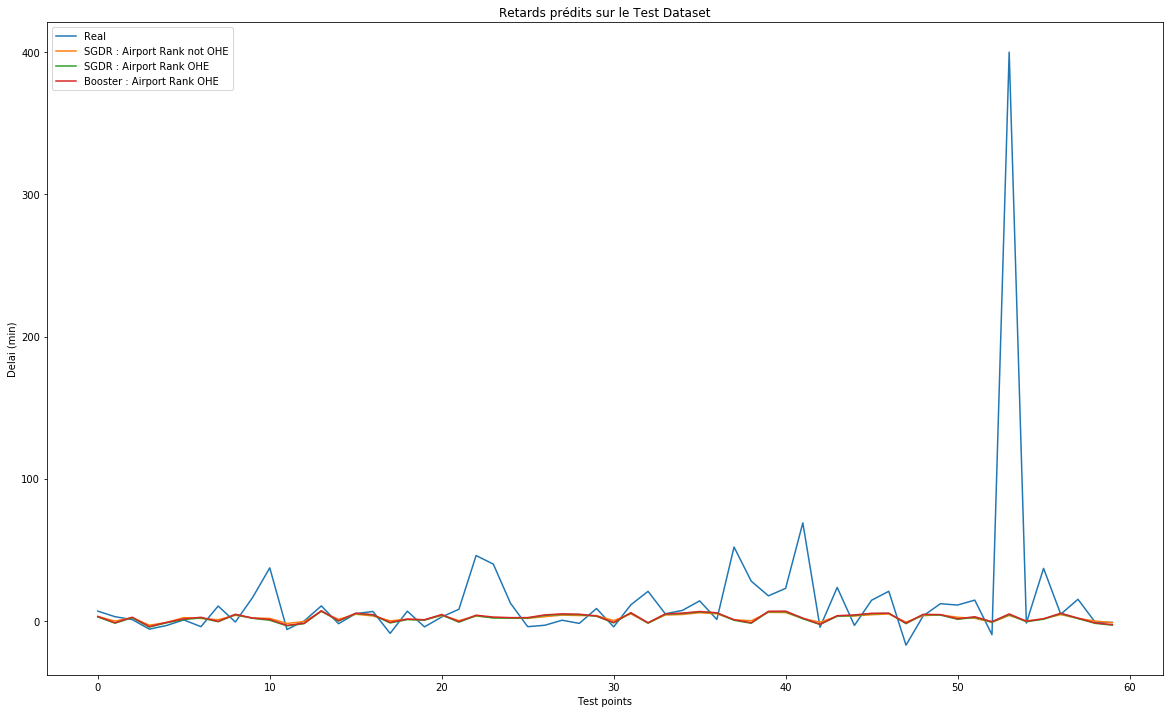

In [24]:
width = 60
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Real")
plt.plot(range(width), y_pred[start:start+width], label="SGDR : Airport Rank not OHE")
plt.plot(range(width), y_pred_OHE[start:start+width], label="SGDR : Airport Rank OHE")
plt.plot(range(width), y_pred_OHE_booster[start:start+width], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset")
plt.savefig("img/predict_zoom_out.png")
plt.show()

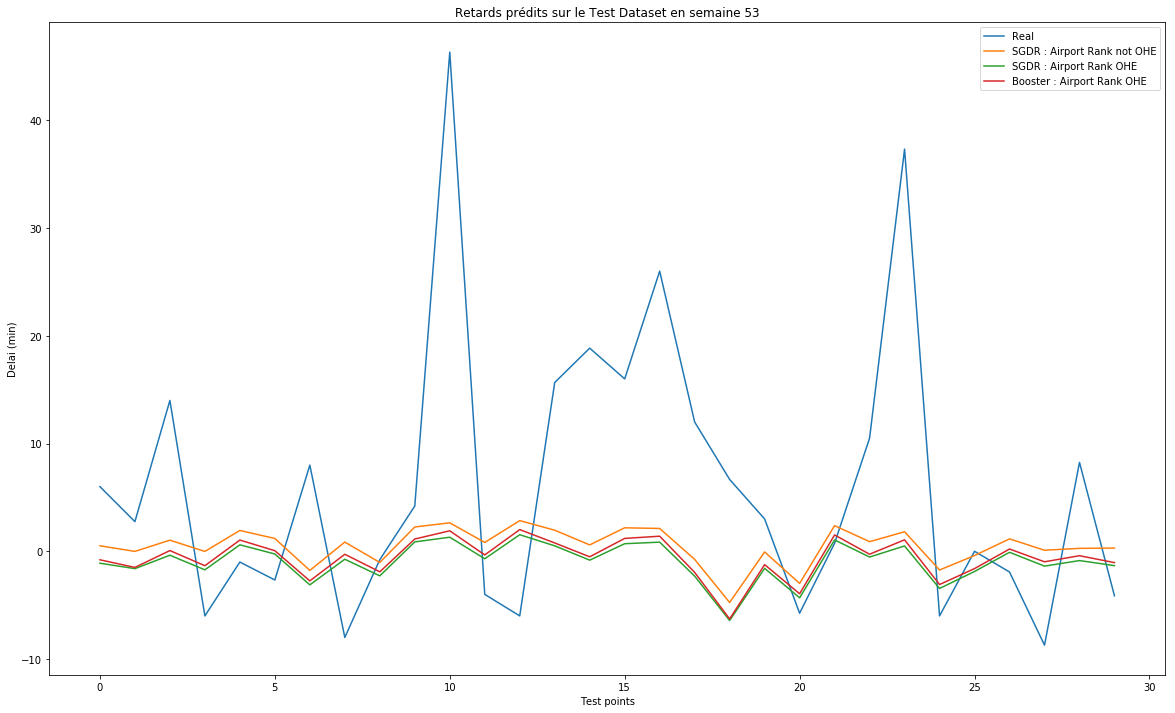

In [28]:
column = list(df_OHE).index("WEEK__53")
index_list = np.where(X_test_OHE[:,column] == 1)[0][:30]
x_range = len(index_list)

plt.figure(figsize=(20,12))
plt.plot(range(x_range), y_test_OHE.reset_index(drop=True).iloc[index_list], label="Real")
plt.plot(range(x_range), y_pred[index_list], label="SGDR : Airport Rank not OHE")
plt.plot(range(x_range), y_pred_OHE[index_list], label="SGDR : Airport Rank OHE")
plt.plot(range(x_range), y_pred_OHE_booster[index_list], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset en semaine 53")
plt.savefig("img/predict_december.png")
plt.show()

On remarque que les tendances sont conservés mais les gros écarts ne sont pas bien "estimés". A cause du lissage par la moyenne et d'un modèle juste linéaire, on underfit le dataset

# Exploration du modele

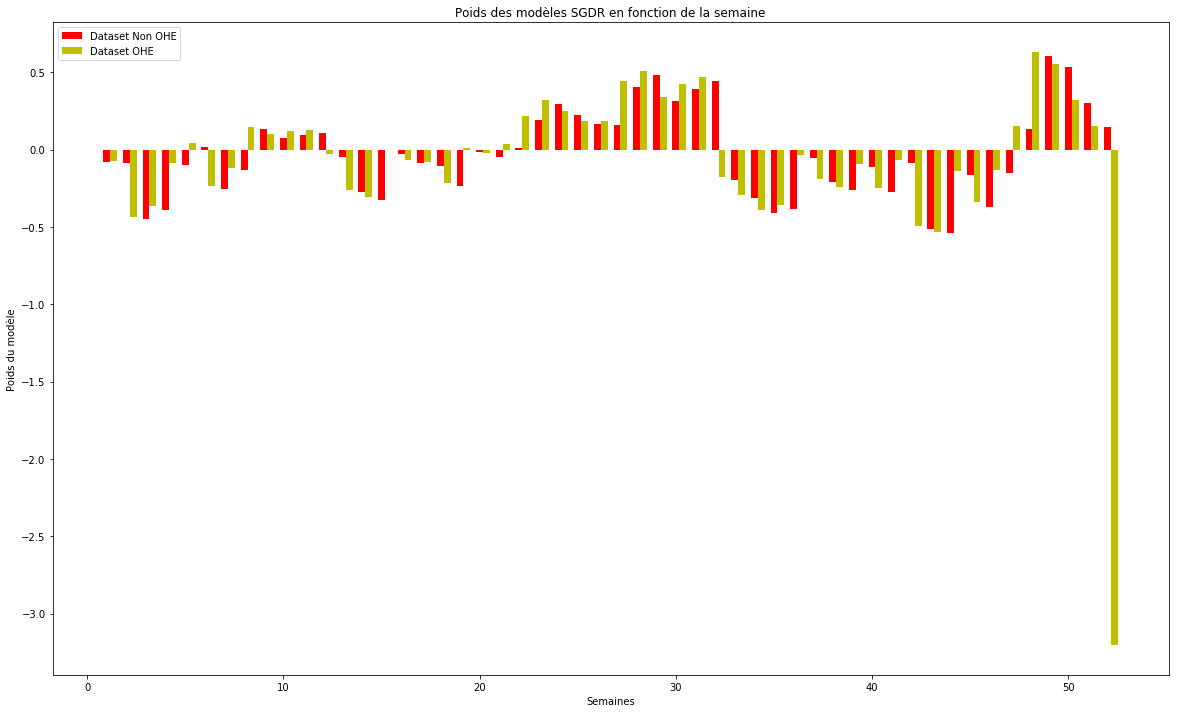

In [34]:
import seaborn as sns 
import pickle

width = 0.35
x = []
x2 = []
y = []
y2 = []
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value.startswith("WEEK_"):
        x.append(int(value[6:]))
        x2.append(int(value[6:])+width)
        y.append(key)
        y2.append(key_ohe)


# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
plt.legend()
# plt.bar(x, y)
# plt.xticks(x_pos, people) 
plt.xlabel("Semaines")
plt.ylabel('Poids du modèle')
plt.title("Poids des modèles SGDR en fonction de la semaine")
plt.savefig("img/weight_week.png")
plt.show()

On remarque des poids forts pour les semaines d'été et proche de noel (sauf le modele avec OHE qui est très différent en semaine 53)

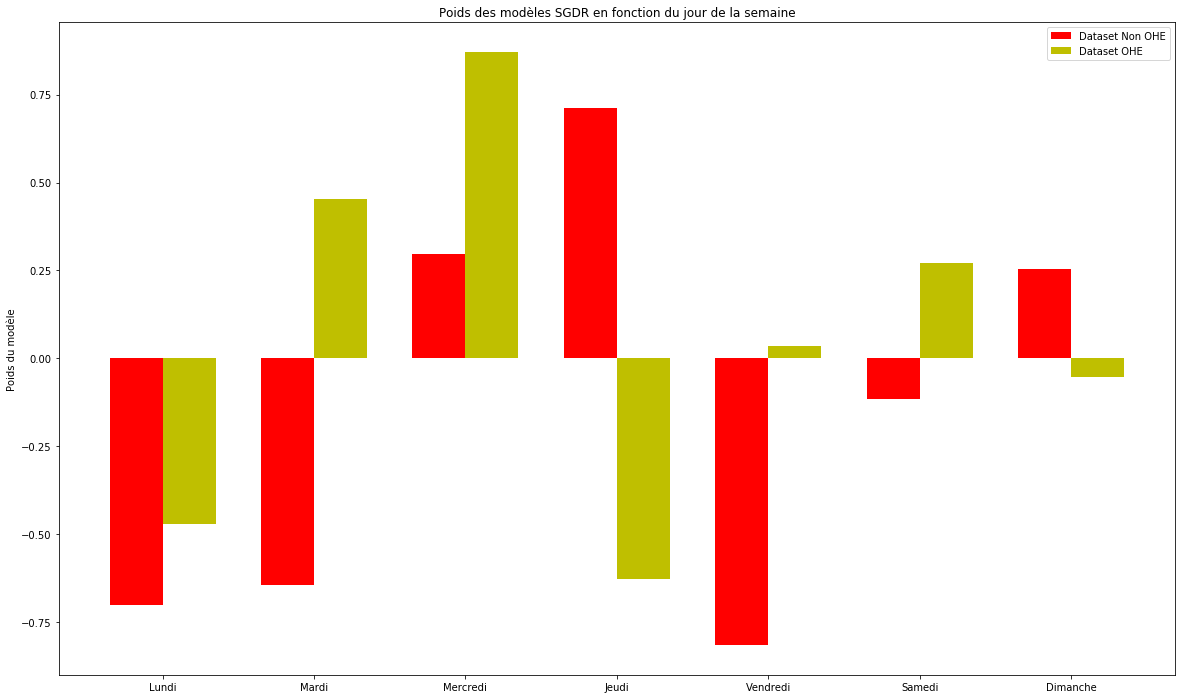

In [40]:
width = 0.35
x = []
x2 = []
y = []
y2 = []
mid = []
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value.startswith("DAY_"):
        x.append(int(value[5:]))
        x2.append(int(value[5:])+width)
        mid.append(int(value[5:])+width/2)
        y.append(key)
        y2.append(key_ohe)

label = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)
plt.legend()
plt.xlabel("")
plt.ylabel('Poids du modèle')
plt.title("Poids des modèles SGDR en fonction du jour de la semaine")
plt.savefig("img/weight_day.png")
plt.show()

Par jour, on remarque des pics d'activités le mardi/mercredi et week end

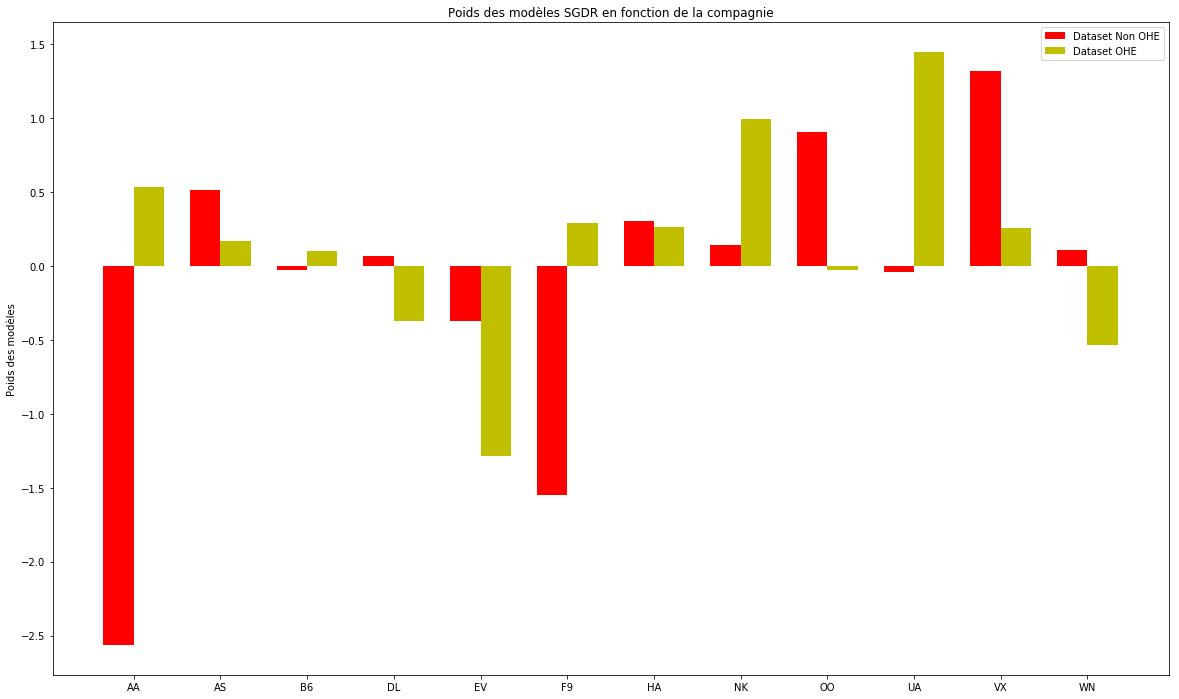

In [41]:
width = 0.35
label = []
x = []
x2 = []
y = []
y2 = []
mid=[]
a = 0
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if len(value) == 2:
        label.append(value)
        y.append(key)
        y2.append(key_ohe)
        x.append(a)
        x2.append(a+width)
        mid.append(a+width/2)
        a += 1

# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)
plt.legend()
plt.ylabel('Poids des modèles')
plt.title("Poids des modèles SGDR en fonction de la compagnie")
plt.savefig("img/weight_compagnie.png")
plt.show()

Les poids associés aux aéroports sont très différents, la variation de poids compense d'autres paramètres (car les 2 MAE sont très proche tout de même)

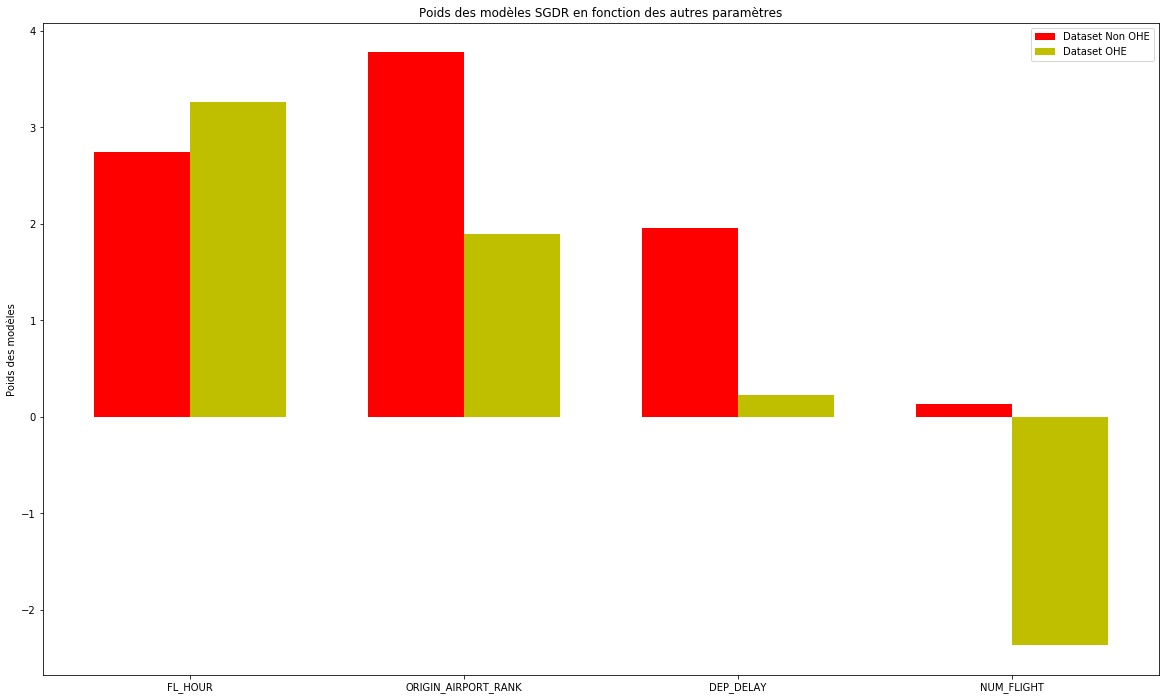

In [42]:
width = 0.35
label = []
x = []
x2 = []
y = []
y2 = []
mid=[]
a = 0
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value in ["FL_HOUR", "ORIGIN_AIRPORT_RANK", "DEP_DELAY", "NUM_FLIGHT"] :
        label.append(value)
        y.append(key)
        y2.append(key_ohe)
        x.append(a)
        x2.append(a+width)
        mid.append((a+width/2))
        a += 1

# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)

plt.legend()
plt.ylabel('Poids des modèles')
plt.title("Poids des modèles SGDR en fonction des autres paramètres")
plt.savefig("img/weight_other.png")
plt.show()

In [43]:
booster.estimator_weights_ 

array([ 4.98532409,  4.81002252,  4.26620337,  2.8442027 ,  1.52233069])

In [44]:
booster.estimator_errors_  

array([ 0.00679113,  0.00808183,  0.01384071,  0.05498176,  0.17911857])

In [45]:
booster.estimators_ 

[SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=981818443, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=1337163725, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=323886239, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        

In [46]:
matrix = []
for weight, model_ in zip(booster.estimator_weights_ , booster.estimators_ ):
    vecteur = weight * np.array(model_.coef_)
    matrix.append(vecteur)

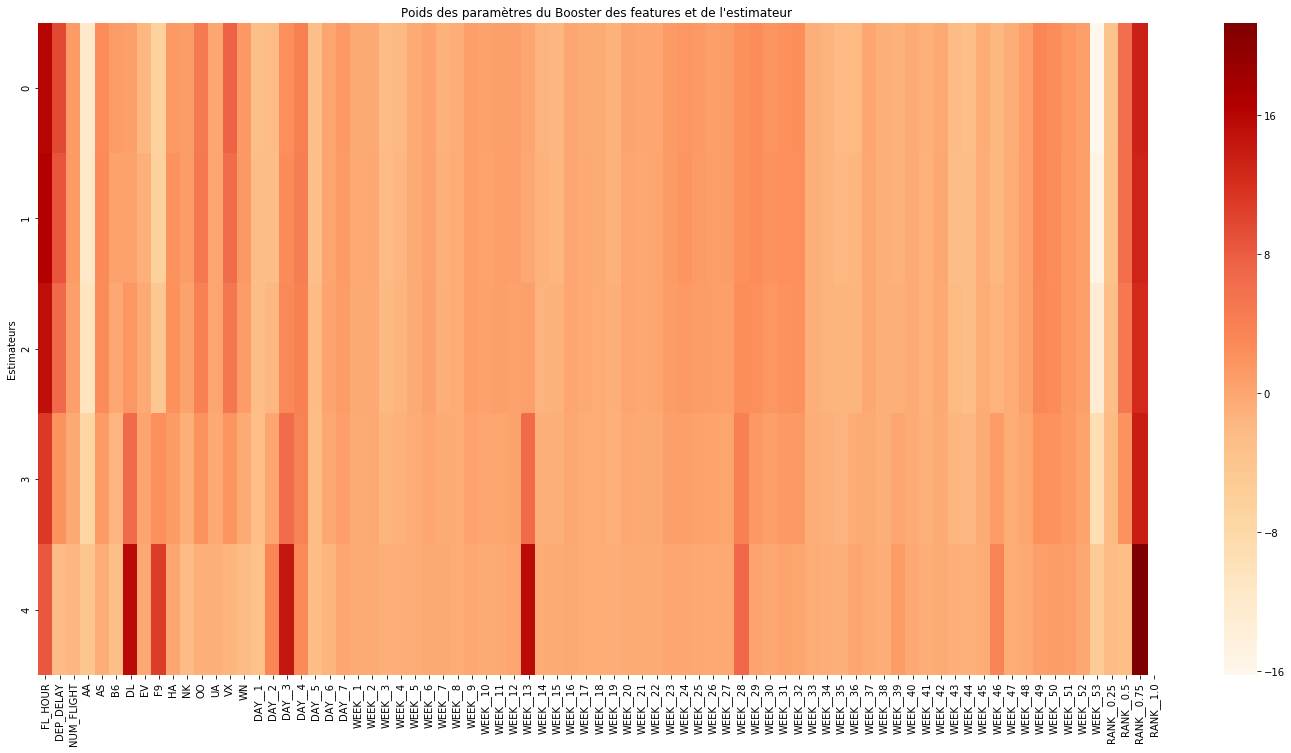

In [47]:
fig, ax = plt.subplots(figsize=(25,12))
ax = sns.heatmap(np.array(matrix), cmap="OrRd")
x_range = [x+0.5 for x in range(len(list(df_OHE)))]
plt.xticks(x_range, list(df_OHE), rotation='vertical')
plt.ylabel('Estimateurs')
plt.title("Poids des paramètres du Booster des features et de l'estimateur")
plt.savefig("img/booster_coeffs.png")
plt.show()

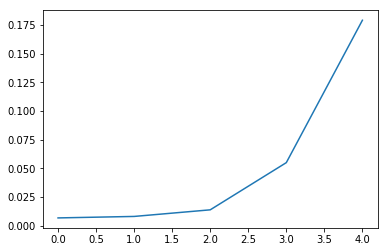

In [46]:
plt.plot(range(5), booster.estimator_errors_ )
plt.show()